In [1]:
%cd ..
import numpy as np
import pandas as pd

C:\Users\Dongmin Kim\Documents\OnlineTSAD


In [2]:
import numpy as np
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():    
    #mat.rcParams['font.family'] = "serif"
    #mat.rcParams['font.serif'] = ["Arial"]
    mat.rcParams['font.family'] = "sans-serif"
    mat.rcParams['font.sans-serif'] = "Times new roman"
    mat.rcParams["axes.titlesize"] = "x-large"
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['lines.color'] = 'r'
    mat.rcParams['axes.grid'] = 1     
    mat.rcParams['axes.xmargin'] = 0.1     
    mat.rcParams['axes.ymargin'] = 0.1     
    mat.rcParams["mathtext.fontset"] = "dejavuserif" #"cm", "stix", etc.
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500
setPlotStyle()

In [15]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [16]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-15 13:45:44,551] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-15 13:45:44,552] Preparing SWaT dataset...
[2023-05-15 13:45:44,553] cur

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-15 13:45:52,765] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-15 13:45:52,837] Complete.
[2023-05-15 13:45:52,837] Preparing dataloader...
[2023-05-15 13:45:53,504] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-15 13:45:53,506] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-15 13:45:53,506] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


In [6]:
import matplotlib.pyplot as plt

In [8]:
normal = pd.read_csv("data/nts_uni_normal.csv")
abnormal = pd.read_csv("data/nts_uni_abnormal.csv")

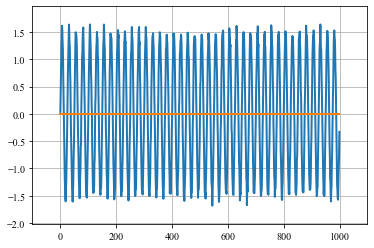

In [9]:
plt.plot(normal)

In [11]:
from utils.tools import plot_interval

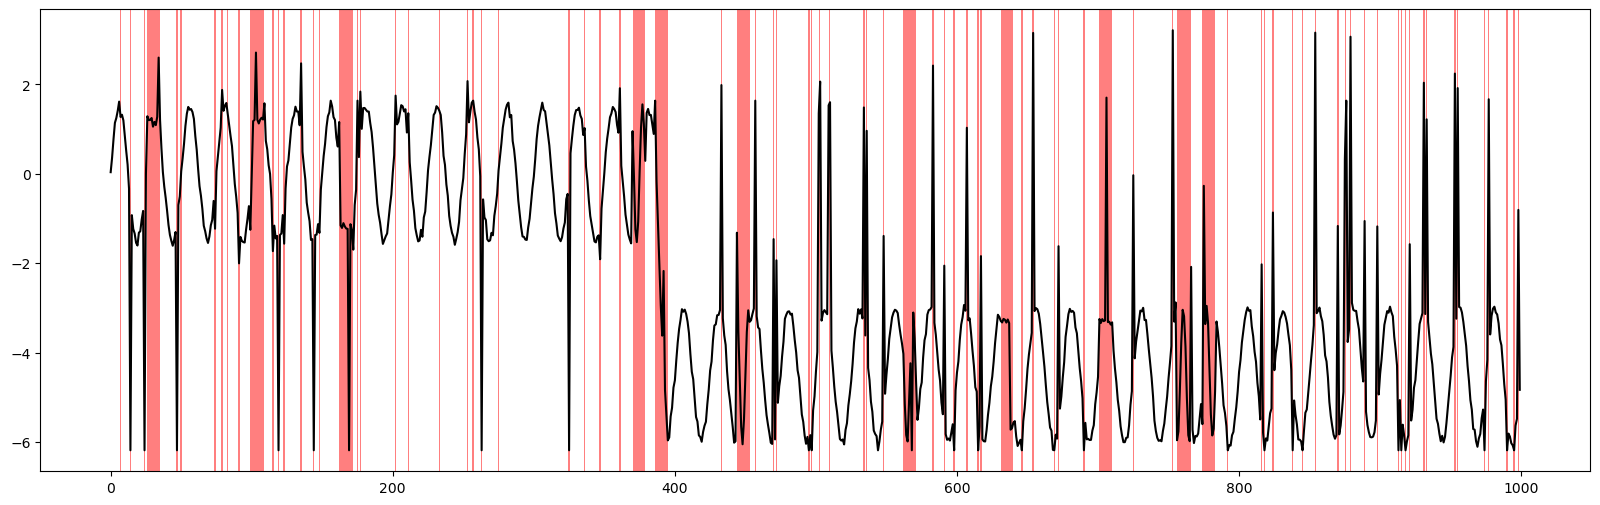

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(abnormal["value"], color="black")
plot_interval(plt, abnormal["anomaly"])
plt.show()

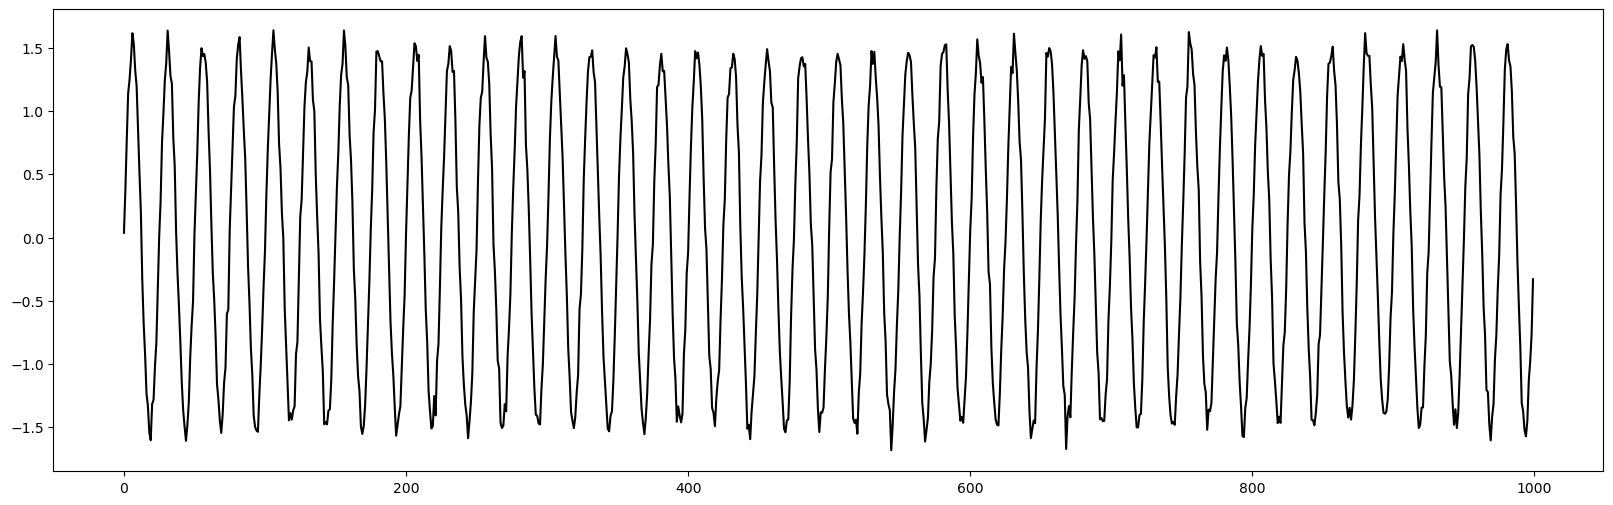

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(normal["value"], color="black")
#plot_interval(plt, abnormal["anomaly"])
plt.show()

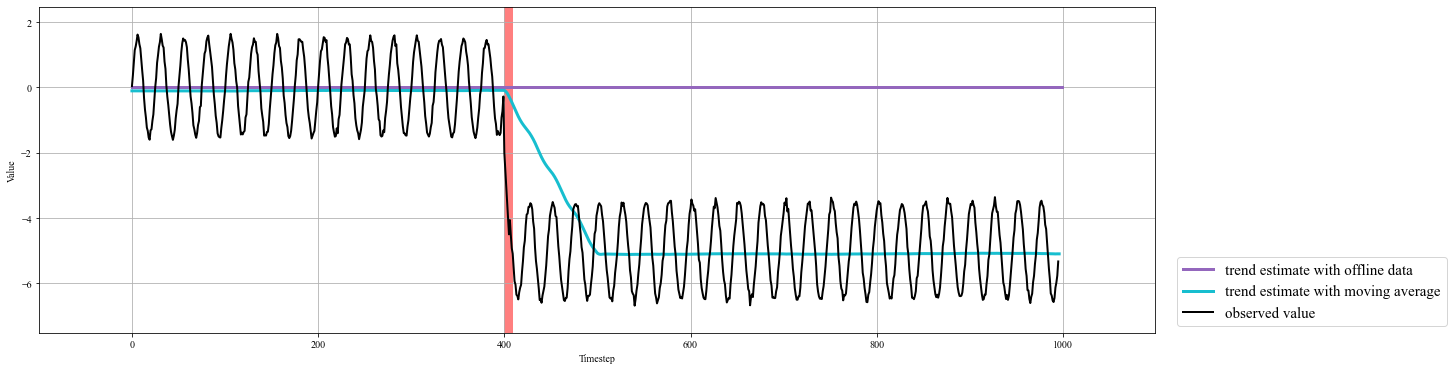

In [17]:
w = 100

nnm = np.concatenate([normal["value"][:400], np.array([x for x in np.arange(-2, -5, -0.5)]), -5+normal["value"][410:]])
ma = np.convolve(nnm, np.ones(w), "valid")/w
ma = np.concatenate([[ma[0]]*w, ma])-0.1
nnm_label = np.array([0]*400+[1]*10+[0]*590)
offline_trend = [normal["value"][:400].mean()]*1000

plt.figure(figsize=(20, 6))
plt.plot(offline_trend, color="C4", linewidth=3, label="trend estimate with offline data")
plt.plot(ma, color="C9", linewidth=3, label="trend estimate with moving average")
plt.plot(nnm, color="black", label="observed value")

plt.xlabel("Timestep")
plt.ylabel("Value")
plot_interval(plt, nnm_label)
plt.legend(loc=(1.02, 0.02))
plt.show()

In [75]:
data = np.concatenate([train_X, test_X])
data_y = np.concatenate([train_y, test_y])
ymu = []
ystd = []
W = 32
for i in range(0, len(data)-W):
    d = data[i:i+W][[not i for i in data_y[i:i+W]]]
    ymu.append(d.mean())
    ystd.append(d.std())
#print(ymu)
#print(len(ymu))
#print(len(ymu+ymu[-1]*W))

ymu=np.array(ymu+[ymu[-1] for _ in range(W)])
ystd=np.array(ystd+[ystd[-1] for _ in range(W)])
x = range(0, len(data))

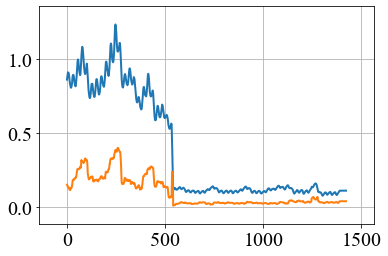

In [76]:
plt.plot(ymu)
plt.plot(ystd)

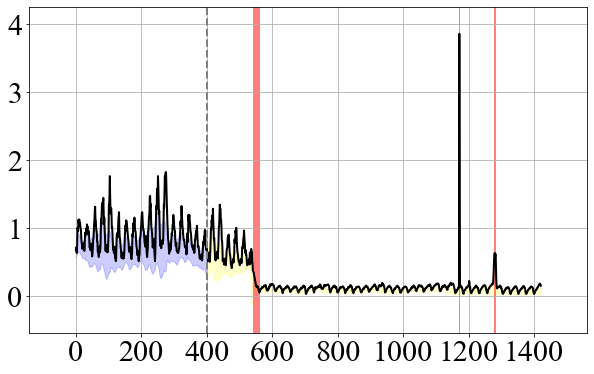

In [80]:
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
plt.figure(figsize=(10, 6))
plt.plot(train_X, color="black")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X, color="black")
plt.axvline(x = 400, color = 'gray', linestyle="dashed")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

cut = 400
plt.fill_between(range(0, cut), ymu[:cut], ymu[:cut]-1.96*ystd[:cut], ymu[:cut]+1.96*ystd[:cut], alpha=0.2, color="blue")
plt.fill_between(range(cut, len(data)), ymu[cut:], ymu[cut:]-1.96*ystd[cut:], 
                 ymu[cut:]+1.96*ystd[cut:], alpha=0.2, color="yellow")

plot_interval(plt, np.concatenate([np.array([0]*len(train_X)), test_y]))
plt.show()

In [43]:
data.shape

(1422, 1)

In [32]:
import matplotlib

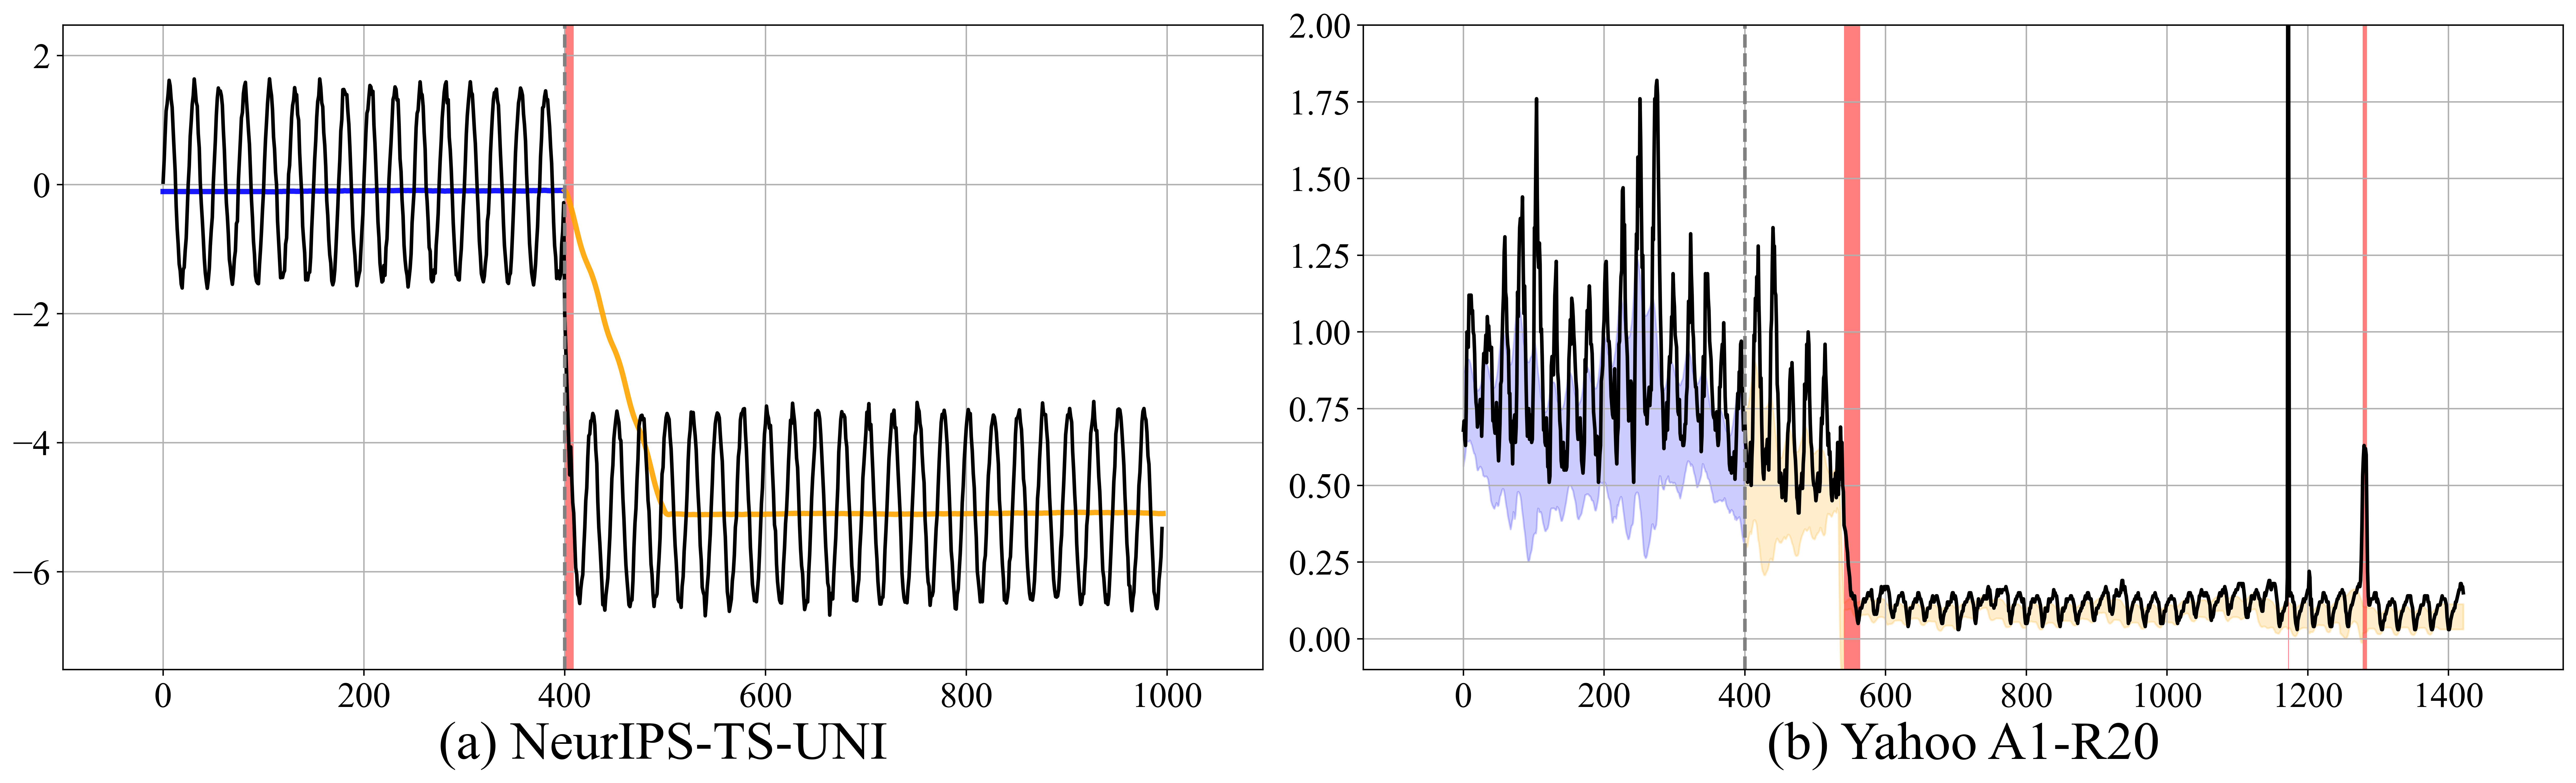

In [94]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(1, 2, figsize=(20, 6), layout='constrained', dpi=500)


w = 100

nnm = np.concatenate([normal["value"][:400], np.array([x for x in np.arange(-2, -5, -0.5)]), -5+normal["value"][410:]])
ma = np.convolve(nnm, np.ones(w), "valid")/w
ma = np.concatenate([[ma[0]]*w, ma])-0.1
nnm_label = np.array([0]*400+[1]*10+[0]*590)
offline_trend = [normal["value"][:400].mean()]*1000

cut = 400
#ax[0].set_title("NeurIPS-TS-UNI", fontsize=20)
ax[0].plot(ma[:cut], color="blue", alpha=0.9, linewidth=3, label="trend estimate with moving average")
ax[0].plot(range(cut, len(ma)), ma[cut:], color="orange", alpha=0.9, linewidth=3, label="trend estimate with moving average")
ax[0].plot(nnm, color="black", label="observed value")
ax[0].axvline(x = cut, color = 'gray', linestyle="dashed")

#plt.xlabel("Timestep")
#plt.ylabel("Value")
plot_interval(ax[0], nnm_label)

#ax[0].figtext(0.50, 0.025, f"(a) NeurIPS-TS-UNI", fontsize=40, ha="center")
ax[0].set_xlabel(f"(a) NeurIPS-TS-UNI", fontsize=30)
#plt.legend(loc=(1.02, 0.02))
#plt.show()


#ax[1].set_title("Yahoo A1-R20", fontsize=20)
ax[1].plot(train_X, color="black")
ax[1].plot(range(len(train_X), len(train_X)+len(test_X)), test_X, color="black")

cut=400
ax[1].fill_between(range(0, cut), ymu[:cut], ymu[:cut]-1.96*ystd[:cut], ymu[:cut]+1.96*ystd[:cut], alpha=0.2, color="blue")
ax[1].fill_between(range(cut, len(data)), ymu[cut:], ymu[cut:]-1.96*ystd[cut:], 
                 ymu[cut:]+1.96*ystd[cut:], alpha=0.2, color="orange")

ax[1].axvline(x = 400, color = 'gray', linestyle="dashed")
ax[1].set_ylim(-0.1, 2)
ax[1].set_xlabel(f"(b) Yahoo A1-R20", fontsize=30)
#ax[1].set_xticks(fontsize=30)
#ax[1].set_yticks(fontsize=30)

plot_interval(ax[1], np.concatenate([np.array([0]*len(train_X)), test_y]))
plt.savefig("./figures/main_figure/illustration_of_needs.pdf", dpi=500, bbox_inches = "tight")
plt.show()

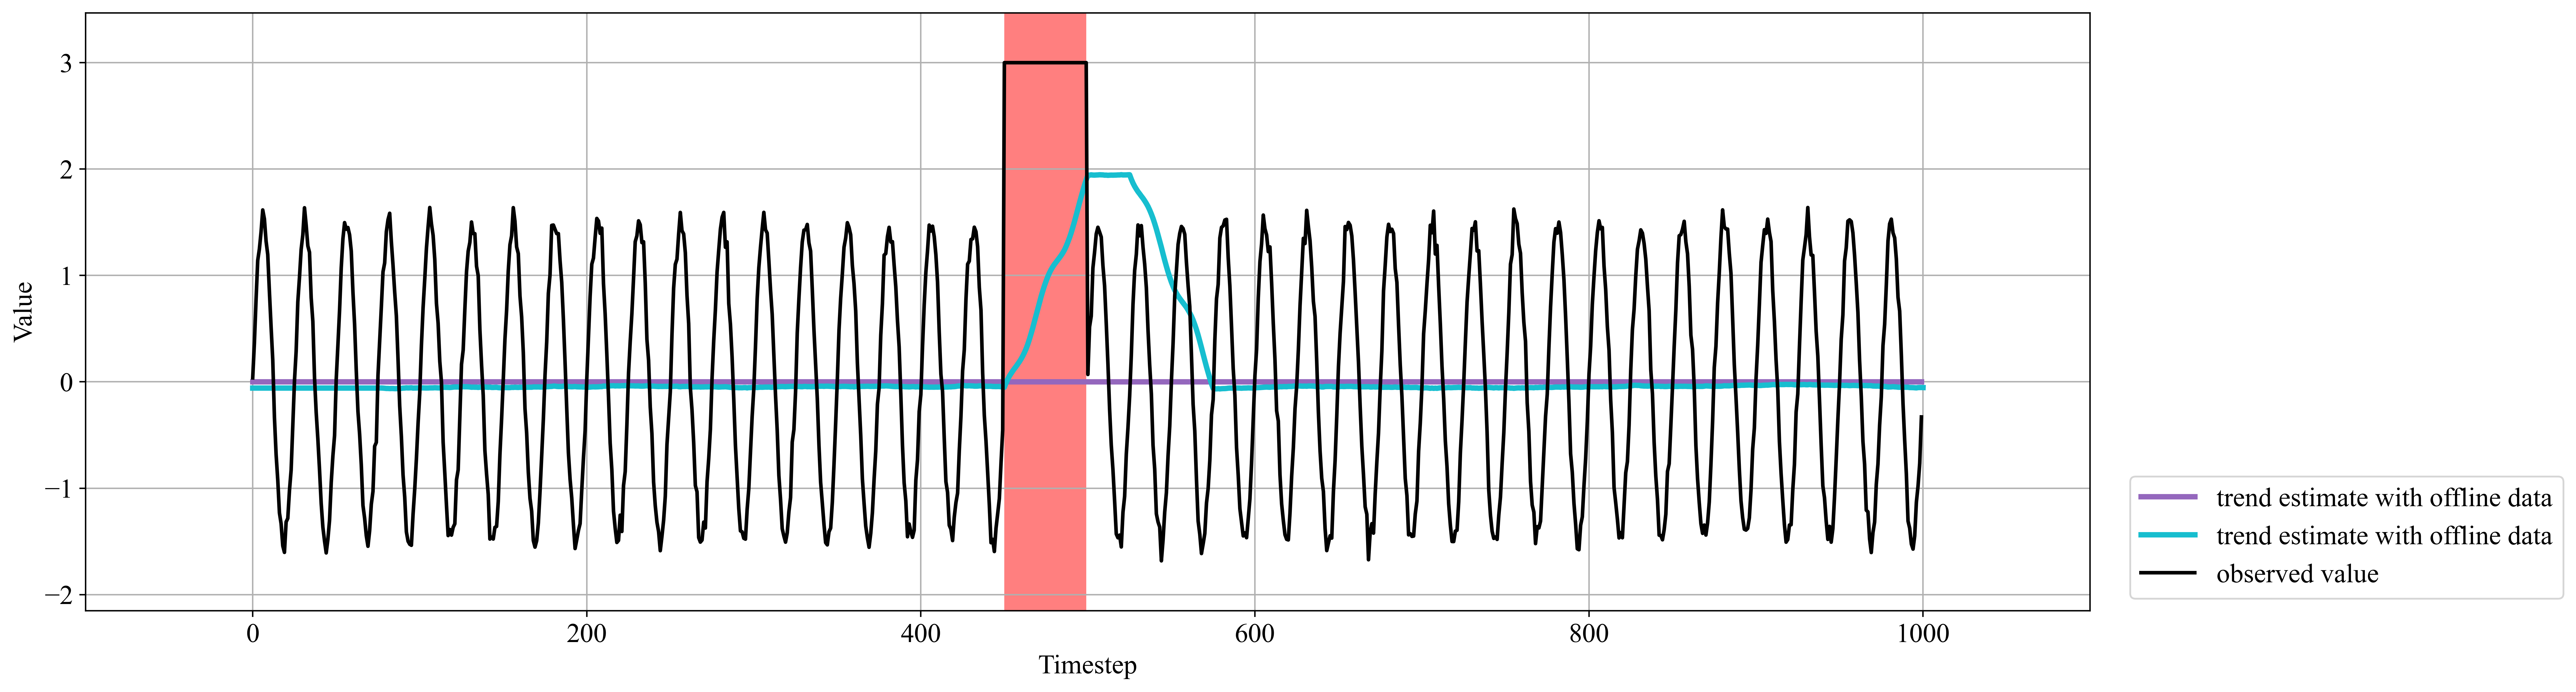

In [95]:
nnm = np.concatenate([normal["value"][:450], np.array([3.0]*50), normal["value"][500:]])
nnm_label = np.array([0]*450+[1]*50+[0]*500)
w = 75
ma = np.convolve(nnm, np.ones(w), "valid")/w
ma = np.concatenate([[ma[0]]*w, ma])-0.05
offline_trend = [normal["value"][:450].mean()]*1000

plt.figure(figsize=(20, 6))

plt.plot(offline_trend, color="C4", linewidth=3, label="trend estimate with offline data")
plt.plot(ma, color="C9", linewidth=3, label="trend estimate with offline data")
plt.plot(nnm, color="black", label="observed value")

plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend(loc=(1.02, 0.02))
plot_interval(plt, nnm_label)
plt.show()